In [1]:
import numpy as np
import cv2
import mediapipe as mp
from mediapipe.python.solutions.face_mesh_connections import FACEMESH_TESSELATION
import json
import networkx as nx
import matplotlib.pyplot as plt
import math
import scipy.sparse
import pathlib, os

In [2]:
mp_face_mes = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
face_mesh = mp_face_mes.FaceMesh(max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)

In [3]:
def preprocess_frame(frame):
    H, W, _ = frame.shape
    rgb_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results_mesh = face_mesh.process(rgb_image)
    mesh_points=np.array([np.multiply([p.x, p.y], [W, H]).astype(int) for p in results_mesh.multi_face_landmarks[0].landmark])
    nose_tip = mesh_points[4]
    forehead = mesh_points[151]
    scale_factor = np.linalg.norm(forehead - nose_tip)
    if np.isclose(scale_factor, 0):
        scale_factor = 1e-6
    return results_mesh, mesh_points, scale_factor

In [14]:
def gera_grafos(results_mesh, mesh_points, scale_factor):
    graph = nx.Graph()
    vertices = []
    x_coords = []
    y_coords = []
    for edge in FACEMESH_TESSELATION:
        pointA_index = edge[0]
        pointB_index = edge[1]
        if pointA_index not in vertices:
            vertices.append(pointA_index)
            graph.add_node(pointA_index)
            x = results_mesh.multi_face_landmarks[0].landmark[pointA_index].x
            y = results_mesh.multi_face_landmarks[0].landmark[pointA_index].y
            x *= scale_factor
            y *= scale_factor
            x *= 100000
            y *= 100000
            x_coords.append(x)
            y_coords.append(y)
        if pointB_index not in vertices:
            vertices.append(pointB_index)
            graph.add_node(pointB_index)
            x = results_mesh.multi_face_landmarks[0].landmark[pointB_index].x
            y = results_mesh.multi_face_landmarks[0].landmark[pointB_index].y
            x *= scale_factor
            y *= scale_factor
            x *= 100000
            y *= 100000
            x_coords.append(x)
            y_coords.append(y)
    return graph, x_coords, y_coords

In [5]:
def plot_graph(graph, mesh_points):
    plt.figure(figsize=(10,10))
    nx.draw_networkx(graph, pos=mesh_points, node_size=10, node_color='black', edge_color='black', with_labels=False)
    # flip the image upside down
    plt.gca().invert_yaxis()
    plt.show()

In [6]:
def get_matrix_adj(graph):
    matrix_adj = nx.adjacency_matrix(graph)
    sparce_matrix = scipy.sparse.csr_matrix(matrix_adj)
    return sparce_matrix    

In [7]:
def save_adjacency_matrix(adjacency_matrix, filename):
    path_name = pathlib.Path(filename).parent.absolute()
    emotion = path_name.name.split('_')[1]
    path_name = path_name.parent.absolute()
    path_name = path_name.joinpath(f'{emotion}_adj')
    # separate the filename from the path
    filename = pathlib.Path(filename).absolute()
    # create te folder if it doesn't exist
    path_name.mkdir(parents=True, exist_ok=True)
    # save the npz file in the path_name
    file_out = path_name.joinpath(f'{filename.name}.npz')
    scipy.sparse.save_npz(file_out, adjacency_matrix)

In [17]:
def save_distance_matrix(distances, filename):
    path_name = pathlib.Path(filename).parent.absolute()
    emotion = path_name.name.split('_')[1]
    path_name = path_name.parent.absolute()
    path_name = path_name.joinpath(f'{emotion}_dist')
    # separete the filename from the path
    filename = pathlib.Path(filename).absolute()
    # create te folder if it doesn't exist
    path_name.mkdir(parents=True, exist_ok=True)
    # save the npz file in the path_name
    file_out = path_name.joinpath(f'{filename.name}.json')
    with open(file_out, 'w') as f:
        json.dump(distances, f)

In [18]:
def save_coordinates(x, y, filename):
    path_name = pathlib.Path(filename).parent.absolute()
    emotion = path_name.name.split('_')[1]
    path_name = path_name.parent.absolute()
    path_name = path_name.joinpath(f'{emotion}_coords')
    # separete the filename from the path
    filename = pathlib.Path(filename).absolute()
    # create te folder if it doesn't exist
    path_name.mkdir(parents=True, exist_ok=True)
    # save the npz file in the path_name
    file_out = path_name.joinpath(f'{filename.name}.json')
    with open(file_out, 'w') as f:
        json.dump({'x': x, 'y': y}, f)

In [16]:
def pipeline(img, plot=False):
    name = img.split('.')[0]
    frame = cv2.imread(img)
    results_mesh, mesh_points, scale_factor = preprocess_frame(frame)
    graph, x, y = gera_grafos(results_mesh, mesh_points, scale_factor)
    adjacency_matrix = get_matrix_adj(graph)
    save_adjacency_matrix(adjacency_matrix, name)
    save_coordinates(x, y, name)
    if plot:
        plot_graph(graph, mesh_points)

## Applying the pipeline to the training set

In [11]:
# print the actual path
print(pathlib.Path().absolute())

c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\GNN


In [12]:
current_path = pathlib.Path().absolute()
path = current_path.parent

angry_path = path / 'face_angry'
disgusted_path = path / 'face_disgusted'
happy_path = path / 'face_happy'
neutral_path = path / 'face_neutral'
sad_path = path / 'face_sad'
surprised_path = path / 'face_surprised'

path_list = [angry_path, disgusted_path, happy_path, neutral_path, sad_path, surprised_path]


c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\face_angry
c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\face_angry\.gitkeep
'NoneType' object has no attribute 'shape'
c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\face_angry\0.jpg


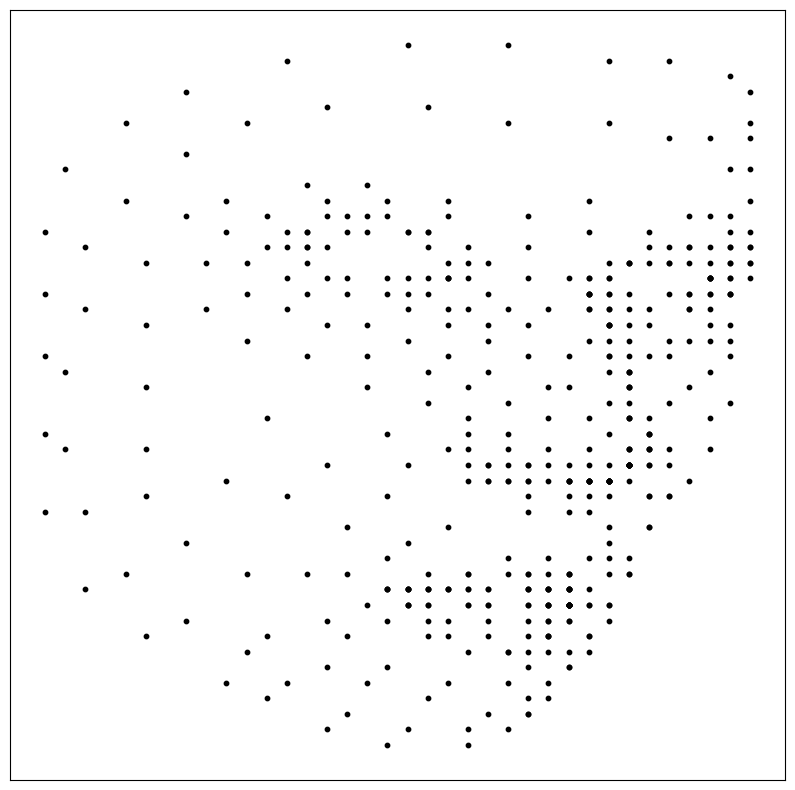

c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\face_angry\1.jpg


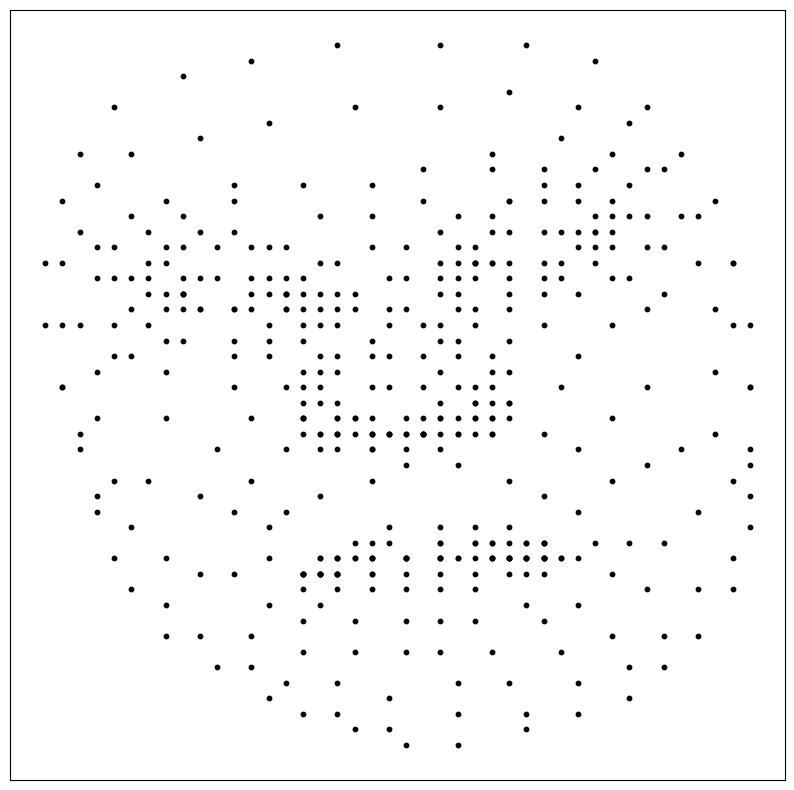

c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\face_angry\10.jpg


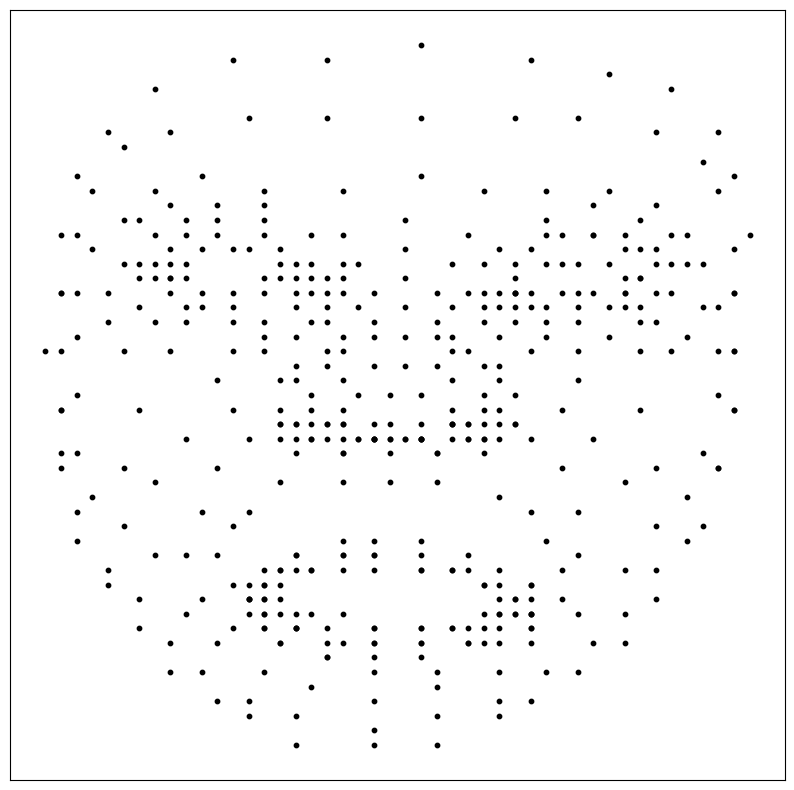

c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\face_angry\10002.jpg


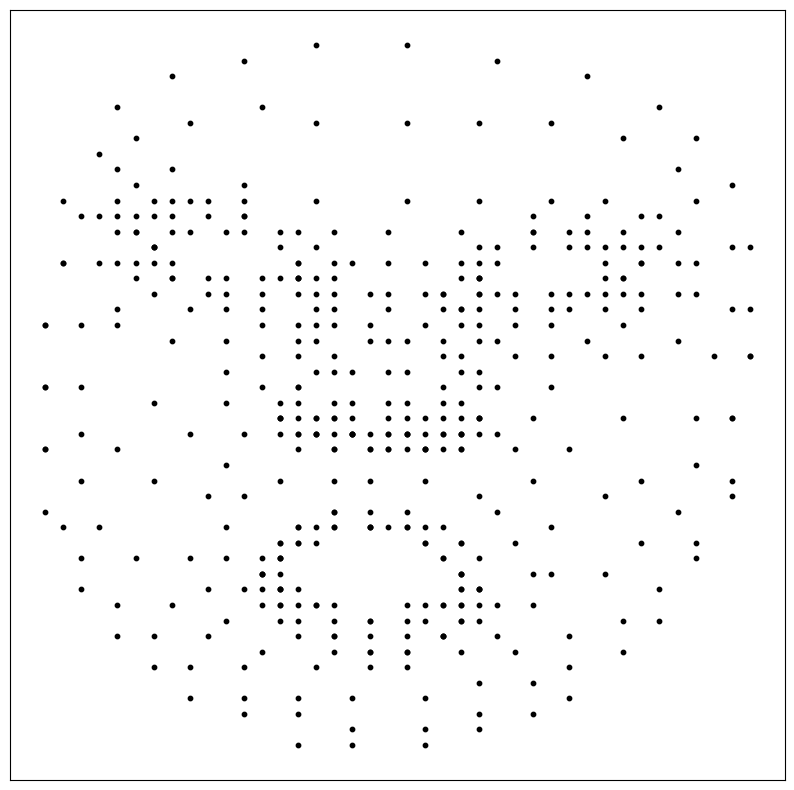

c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\face_angry\10016.jpg


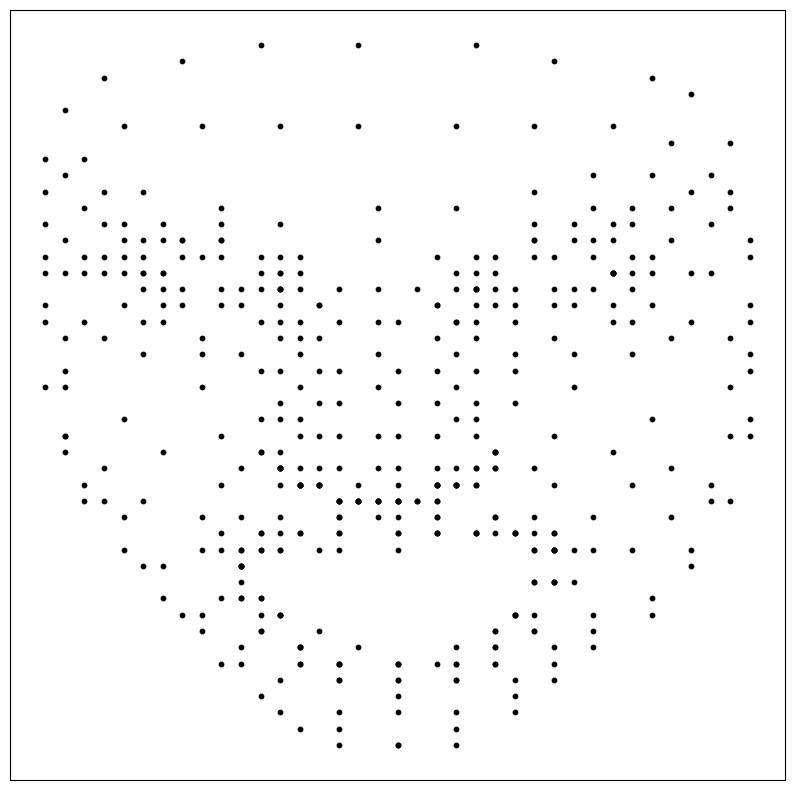

c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\face_angry\10038.jpg


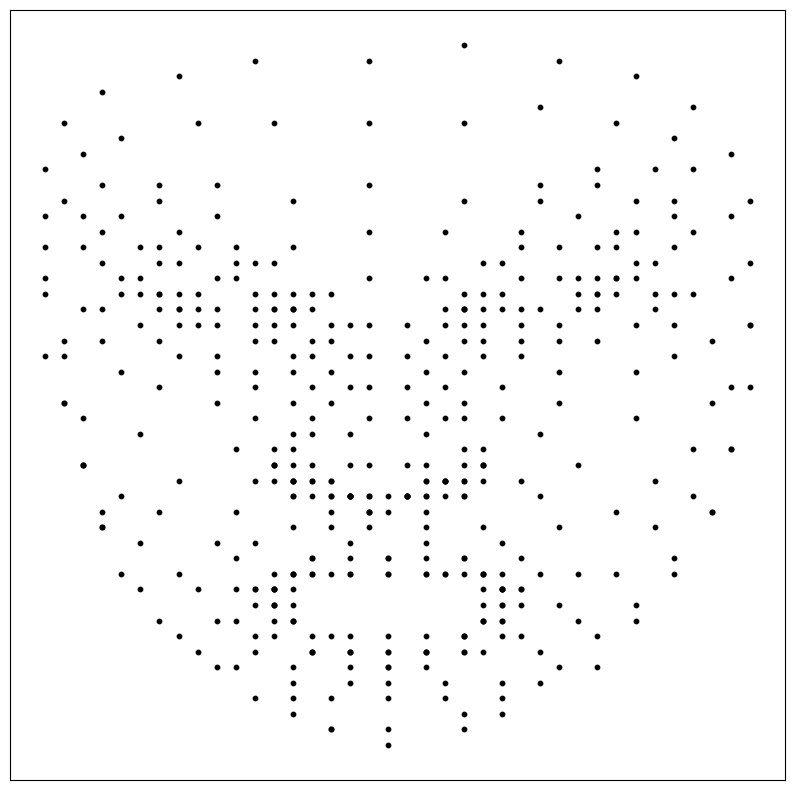

c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\face_angry\10052.jpg


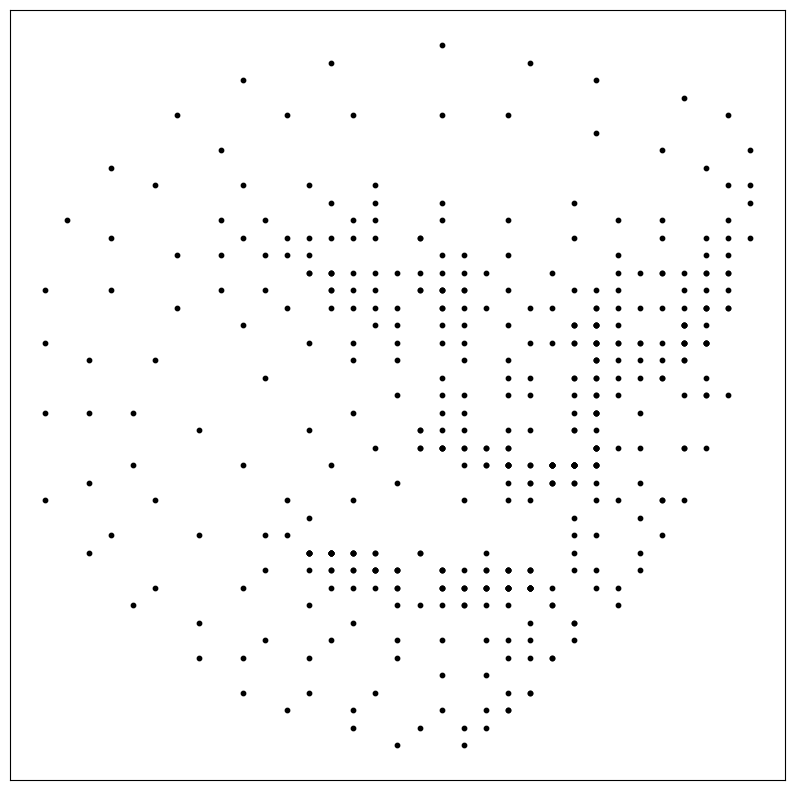

c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\face_angry\10063.jpg


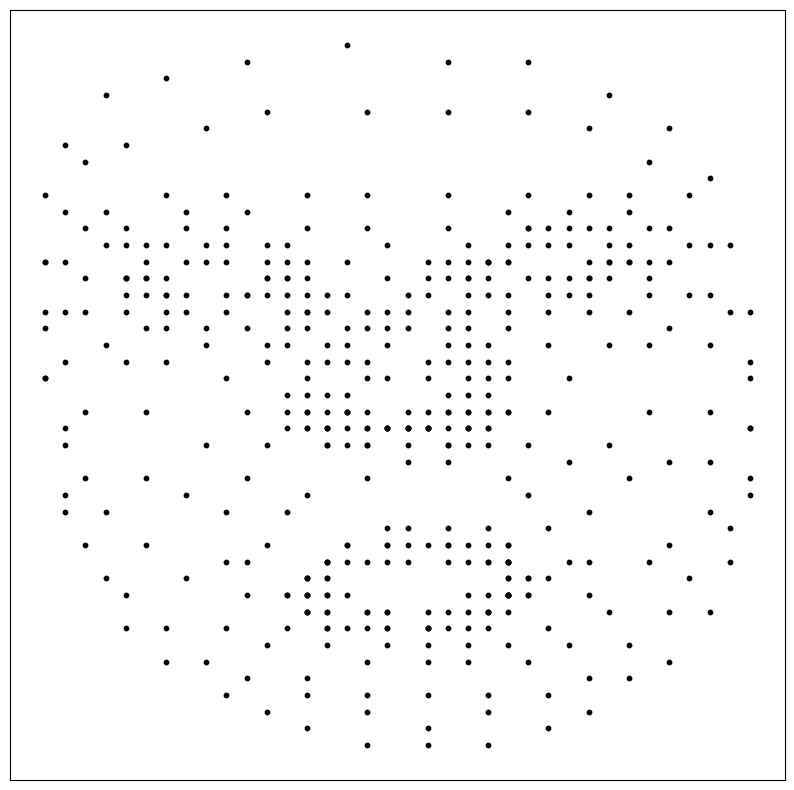

c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\face_angry\10065.jpg


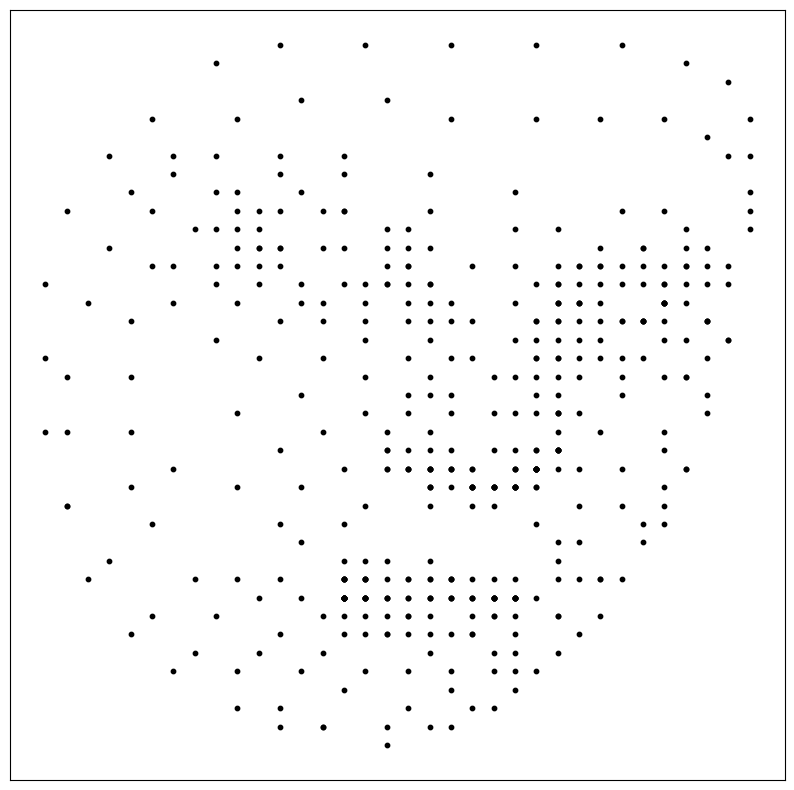

c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\face_angry\10069.jpg


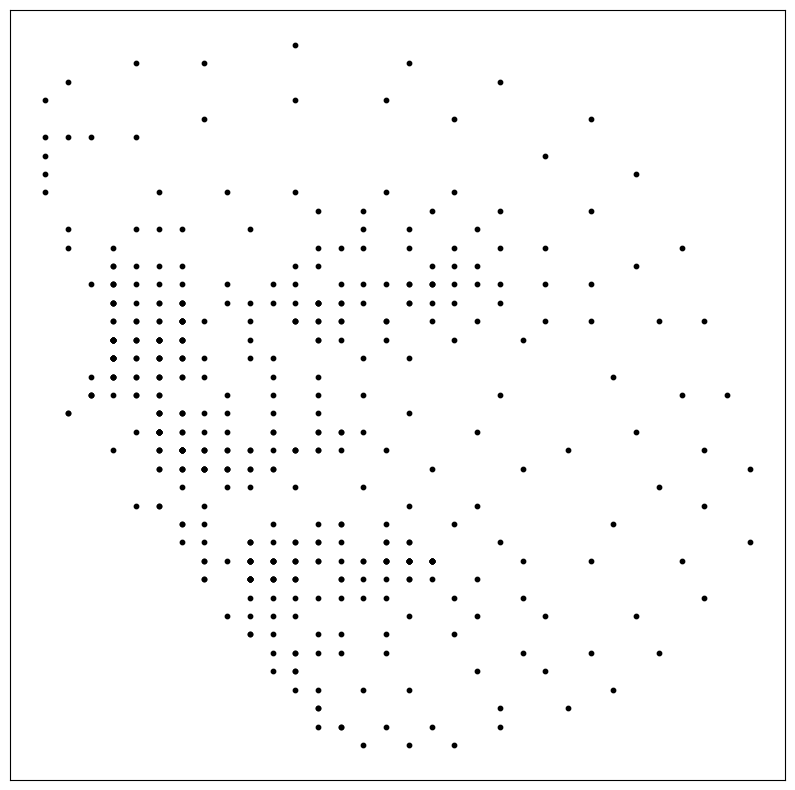

c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\face_angry\10079.jpg


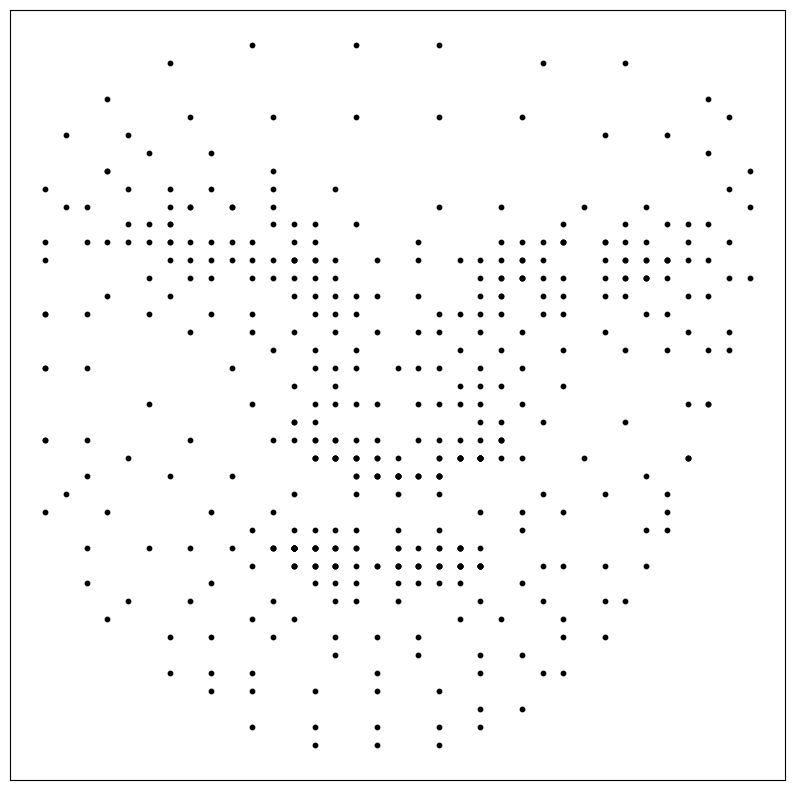

1


In [20]:
for emotion_path in path_list:
    count = 0
    p_c = 0
    print(emotion_path)
    emotion_files = os.listdir(emotion_path)
    for img in emotion_files:
        try:
            path_img = emotion_path / img
            print(path_img)
            pipeline(str(path_img), plot=True)
            if p_c == 10:
                break
            p_c += 1
        except Exception as e:
            print(e)
            count += 1
            if count == 3:
                break
    print(count)
    break

In [22]:
for emotion_path in path_list:
    count = 0
    img_count =1
    print(emotion_path)
    emotion_files = os.listdir(emotion_path)
    for img in emotion_files:
        try:
            if (img_count/len(emotion_files)) > 0.1:
                break
            path_img = emotion_path / img
            pipeline(str(path_img), plot=False)
            img_count += 1
        except Exception as e:
            #print(e)
            count += 1
            continue
    print('erros',count)

c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\face_angry
erros 71
c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\face_disgusted
erros 25
c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\face_happy
erros 103
c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\face_neutral
erros 89
c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\face_sad
erros 203
c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\face_surprised
erros 26


In [16]:
# print the amount of processed images
for emotion_path in path_list:
    print(len(os.listdir(emotion_path)))

4283
1718
8996
7504
8391
4283


In [17]:
# test 
# load 10 npz files from the folder angry_adj

# load the npz file
# the npz file is a sparse matrix

adj_angry_path = path / 'angry_adj'
print(adj_angry_path)

matrix_list = []

for file in os.listdir(adj_angry_path)[:10]:
    file_path = adj_angry_path / file
    sparse_matrix = scipy.sparse.load_npz(file_path)
    sparse_matrix = sparse_matrix.todense()
    print(sparse_matrix.shape)
    matrix_list.append(sparse_matrix)

# compara a matriz de adjacência de duas imagens
for i in range(len(matrix_list)):
    for j in range(i+1, len(matrix_list)):
        # print if any of the matrix is different
        if not np.array_equal(matrix_list[i], matrix_list[j]):
            print(f'{i} and {j} are different')
        else:
            print(f'{i} and {j} are equal')

c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\Facial-Emotion-Classification-Graph_Fork\angry_adj
(468, 468)
(468, 468)
(468, 468)
(468, 468)
(468, 468)
(468, 468)
(468, 468)
(468, 468)
(468, 468)
(468, 468)
0 and 1 are equal
0 and 2 are equal
0 and 3 are equal
0 and 4 are equal
0 and 5 are equal
0 and 6 are equal
0 and 7 are equal
0 and 8 are equal
0 and 9 are equal
1 and 2 are equal
1 and 3 are equal
1 and 4 are equal
1 and 5 are equal
1 and 6 are equal
1 and 7 are equal
1 and 8 are equal
1 and 9 are equal
2 and 3 are equal
2 and 4 are equal
2 and 5 are equal
2 and 6 are equal
2 and 7 are equal
2 and 8 are equal
2 and 9 are equal
3 and 4 are equal
3 and 5 are equal
3 and 6 are equal
3 and 7 are equal
3 and 8 are equal
3 and 9 are equal
4 and 5 are equal
4 and 6 are equal
4 and 7 are equal
4 and 8 are equal
4 and 9 are equal
5 and 6 are equal
5 and 7 are equal
5 and 8 are equal
5 and 9 are equal
6 and 7 are equal
6 and 8 are equal
6 and 9 are equal
7 and 8 are equal
7 and 9 are